<a href="https://colab.research.google.com/github/walt-r/hate_speech_nlp/blob/main/nlp_proj_hate_speach_classifier_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Classification
## Detect toxic content to improve online conversations
Inspired by quora_classifier_lstm_new


In [ ]:
!wget https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv -O hate_speech_data.csv
# !wget https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.p -O hate_speech_data.p

--2021-03-24 23:58:40--  https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘hate_speech_data.csv’

hate_speech_data.cs     [ <=>                ] 104.48K  --.-KB/s    in 0.009s  

2021-03-24 23:58:40 (11.0 MB/s) - ‘hate_speech_data.csv’ saved [106991]



In [ ]:
import random
import os
from datetime import datetime
import pandas as pd

import torch   
from torchtext import data 
from torch.autograd import Variable

In [ ]:
#Reproducing same results
SEED = 2315

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

### Load custom dataset

# Missing 30% of data from error

In [ ]:
df = pd.read_csv('labeled_data_index.csv') #, error_bad_lines=False) 
# df = pd.read_csv('hate_speech_data.csv') #, error_bad_lines=False) 

# df = pd.read_pickle('hate_speech_data.p')

print (f"Number of records: {len(df)}")

df.head()

Number of records: 24783


,index,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df['class'].unique()
df['count'].unique()
df['class'].value_counts()
# class 0 is hate_speach; 1 is offensive language; 2 is neither
# df[df['class'] == 0]['tweet'].to_list()[-10:]

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [ ]:
# df[df['class'] < 2]['class'].value_counts()
df['target'] = df['class'].apply(lambda x: 1 if x == 2 else 0)

In [ ]:
df['target'].value_counts()

0    20620
1     4163
Name: target, dtype: int64

In [ ]:
# find and drop percent of target == 0 rows
import random

random.seed(42)
print(df.shape)
# df[df['target']==0].index.to_list()
drop_offensive = random.sample(df[df['target']==0].index.to_list(), 15000)

(24783, 8)


In [ ]:
df = df.drop(index = drop_offensive)
df['target'].value_counts()

0    5620
1    4163
Name: target, dtype: int64

In [ ]:
df['length'] = df['tweet'].apply(lambda s: len(s.split()))
df.sort_values(by=['length'], ascending=False, inplace=True)

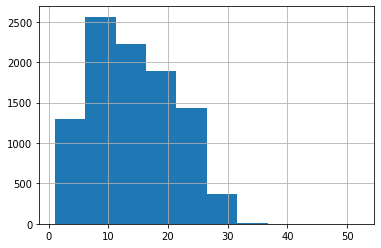

In [ ]:
df['length'].hist()

In [ ]:
print(df[(df['length'] >= 5) & (df['length'] <= 28)].shape)
df = df[(df['length'] >= 5) & (df['length'] <= 30)]

(9125, 9)


In [ ]:
df.head()

,index,count,hate_speech,offensive_language,neither,class,tweet,target,length
10429,10707,3,0,3,0,1,I hate a bitch that love a bitch that say she ...,0,30
7441,7652,3,1,2,0,1,A lady approached me asking me if I was religi...,0,30
11510,11803,3,1,2,0,1,If I were born black; \nI would have tons of k...,0,30
24266,24770,3,1,2,0,1,niggas are jus like btchs talking bout a hoe t...,0,30
8186,8413,3,2,1,0,0,"Bro everybody is a ho then, fuck it, your favo...",0,30


In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')

In [ ]:
# This step takes few minutes

counter = Counter()
for _, row in df.iterrows():
    counter.update(tokenizer(row['tweet']))

vocab = Vocab(counter, min_freq=1)

In [ ]:
print(f"Size of TEXT vocabulary: {len(vocab)}\n")

print(f"Commonly used words: {vocab.freqs.most_common(10)}\n")

Size of TEXT vocabulary: 22678

Commonly used words: [('.', 9742), ("'", 3860), ('i', 3637), ('a', 3520), ('the', 3277), ('rt', 3021), (',', 2669), ('you', 2271), ('to', 2162), ('bitch', 2070)]



In [ ]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

label_pipeline = lambda x: int(x)

### Custom DataLoader

In [ ]:
#Split into training and validation datasets

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.5)
train, valid = train_test_split(train, test_size=0.4)

train.sort_values(by=['length'], ascending=False, inplace=True)
test.sort_values(by=['length'], ascending=False, inplace=True)
valid.sort_values(by=['length'], ascending=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
test

,index,count,hate_speech,offensive_language,neither,class,tweet,target,length
23694,24188,3,1,2,0,1,but I'd rather be a free man in my grave\nthan...,0,30
17495,17893,3,0,0,3,2,RT @SweetiePaii: RT if you listen to these ban...,1,30
10856,11138,3,0,3,0,1,I remember when this lil bitch caught me slipp...,0,30
8186,8413,3,2,1,0,0,"Bro everybody is a ho then, fuck it, your favo...",0,30
10099,10372,3,0,1,2,2,"I can jig, but I can't jig jig. &#128514; like...",1,30
...,...,...,...,...,...,...,...,...,...
24414,24920,3,0,1,2,2,sheryl crow being the bae,1,5
21182,21640,3,0,2,1,1,"Stop using the word ""redskin(s)"".",0,5
800,816,3,0,0,3,2,#WhatImCraving Peanut Butter Oreos &lt;3,1,5
9477,9737,3,0,3,0,1,Gold diggin ass bitch lol,0,5


In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

def generate_batch(batch):
    label_list, text_list, text_length_list = [], [], []
    SEQSIZE = len(batch[0]['tweet'].split())
    for row in batch:
        _text = row['tweet']
        _label = row['target'] 
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)[:SEQSIZE]
        text_length_list.append(len(processed_text))
        processed_text += [1]*(SEQSIZE-len(processed_text))
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    text_list = torch.tensor(text_list, dtype=torch.int64)
    text_length_list = torch.tensor(text_length_list, dtype=torch.int64)
    return label_list.to(device), text_list.to(device), text_length_list
    
batch_size = 64

dataloader_train = DataLoader(PandasDataset(train), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

dataloader_test = DataLoader(PandasDataset(test), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

dataloader_valid = DataLoader(PandasDataset(valid), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [ ]:
len(dataloader_train)

44

### LSTM Classifier

In [ ]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths,
                                                            batch_first=True,
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs


#### Instantiate a LSTM Classifier model

In [ ]:
#define hyperparameters
size_of_vocab = len(vocab)
embedding_dim = 100
hidden_dim = 32
output_dim = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, hidden_dim, output_dim, num_layers, 
                   bidirectional = True, dropout = dropout)



In [ ]:
#architecture
print(model)

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

# #Initialize the pretrained embedding  ()
# pretrained_embeddings = TEXT.vocab.vectors
# # model.embedding.weight.data.copy_(pretrained_embeddings) # TODO PLEASE USE THIS FOR LSTM

# print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(22678, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 2,327,257 trainable parameters


In [ ]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
device

device(type='cuda')

### Model Train function 

In [ ]:
def train(model, dataloader, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for idx, (label, text, text_lengths) in enumerate(dataloader):
        
        #resets the gradients after every batch
        optimizer.zero_grad()   

        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()
    
        #compute the loss
        loss = criterion(predictions, label)
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
        if idx % 1000 == 0:
            print (f"Completed {idx}/{len(dataloader)}")
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Model Evaluate function

In [ ]:
def evaluate(model, dataloader, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for _, (label, text, text_lengths) in enumerate(dataloader):
        
            #predict
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Check model's forward pass

In [ ]:
#Check model device type
next(model.parameters()).is_cuda, device

(True, device(type='cuda'))

In [ ]:
len(dataloader_train)

44

In [ ]:
for idx, (label, text, text_lengths) in enumerate(dataloader_train):
    print ("text.shape: ", text.shape)
    predictions = model(text, text_lengths)
    print ("predictions.shape: ", predictions.shape)
    break

text.shape:  torch.Size([64, 30])
predictions.shape:  torch.Size([64, 1])


In [ ]:
text[0], predictions[0][:10], label[:10]

(tensor([  67,   32, 1479,  150,   99,  663,   48,   77,    5,  282,   16,    3,
           22,   47,  241,    8,    4,  150,  217,    4,  295,   60,  432,   28,
            5,  282,   47,  322,   77,  217], device='cuda:0'),
 tensor([0.5365], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0'))

### Train the model

This step takes around ~4 min

In [ ]:
model_path = 'saved_weights.pt'

N_EPOCHS = 5
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    ts_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
    print(f'\n {ts_string} Epoch: {epoch}')
    #train the model
    train_loss, train_acc = train(model, dataloader_train, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, dataloader_valid, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)

    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


 03/25/2021 03:50:21 Epoch: 0
Completed 0/44
	 Train Loss: 0.232 | Train Acc: 91.05%
	 Val. Loss: 0.447 |  Val. Acc: 81.64%

 03/25/2021 03:50:22 Epoch: 1
Completed 0/44
	 Train Loss: 0.141 | Train Acc: 95.49%
	 Val. Loss: 0.526 |  Val. Acc: 81.27%

 03/25/2021 03:50:23 Epoch: 2
Completed 0/44
	 Train Loss: 0.096 | Train Acc: 96.98%
	 Val. Loss: 0.530 |  Val. Acc: 83.48%

 03/25/2021 03:50:24 Epoch: 3
Completed 0/44
	 Train Loss: 0.079 | Train Acc: 97.80%
	 Val. Loss: 0.509 |  Val. Acc: 84.09%

 03/25/2021 03:50:25 Epoch: 4
Completed 0/44
	 Train Loss: 0.080 | Train Acc: 97.44%
	 Val. Loss: 0.517 |  Val. Acc: 83.13%


### Predict

In [ ]:
#load weights
#model.load_state_dict(torch.load(model_path));
model.eval();

def prepare_text(sentence):
    text = text_pipeline(sentence)
    text_length = len(text)
    tensor = torch.tensor(text, dtype=torch.int64)
    length = torch.tensor(text_length, dtype=torch.int64)
    tensor = tensor.unsqueeze(0)
    length = length.unsqueeze(0)
    return tensor.to(device), length

def predict(model, sentence):
    tensor, length = prepare_text(sentence)
    prediction = model(tensor, length)                  #prediction 
    return prediction.item()  

In [ ]:
def insincere_or_not(pred):
    return 'Not Offensive' if pred > .5 else 'Hate Speech or Offensive'

In [ ]:
#sincere question
pred = predict(model, "What is your favorite person in history?")
print (insincere_or_not(pred))

Not Offensive


In [ ]:
#insincere question
pred = predict(model, "Ur a faggot and a bitch")
print (insincere_or_not(pred))

Hate Speech or Offensive


### Note

This notebook used data and code from a blog in https://www.analyticsvidhya.com